In [2]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import corner
from copy import deepcopy
import glob
from tqdm import tqdm
from scipy.special import logsumexp
import os 

import sys
sys.path.append('../')
from populations import bbh_models, gw_obs
import populations.bbh_models as read_models
from populations.bbh_models import read_hdf5
from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [3]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
channels =['CE', 'CHE', 'GC', 'NSC', 'SMT']
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gwtc3_events/events_processed/events_processed'
np.random.seed(314)
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            10000, 'posteriors', 'p_theta_jcb')

model_names, flow = read_models.get_models(file_path, channels, params, use_flows=True, use_unityweights=False, device='cpu',\
     no_bins=[5,4,4,5,4])
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_150124_extralong/flow_models/"
for chnl in channels: flow[chnl].load_model(flow_path, chnl)

[135]
[3724 7295]
[  11   21   27 ... 9974 9976 9991]
[ 239  253  466  484  551  556  634  687  773  825  907  944  990 1002
 1024 1029 1097 1154 1178 1299 1357 1381 1475 1640 1693 1707 1858 1925
 2009 2153 2176 2237 2394 2429 2443 2517 2701 2839 2918 2943 3047 3083
 3105 3314 3345 3401 3469 3478 3581 3700 3711 3733 3742 3746 3861 3900
 3969 3983 4034 4094 4099 4114 4149 4153 4169 4244 4622 4634 4770 4773
 4878 4881 4921 4946 5078 5092 5101 5112 5199 5203 5234 5268 5304 5357
 5433 5440 5489 5537 5673 5730 5757 5938 6033 6085 6206 6278 6297 6349
 6727 6780 6782 6860 6875 6889 6945 7126 7193 7197 7217 7258 7420 7475
 7488 7507 7562 7623 7632 8174 8188 8281 8287 8293 8313 8351 8412 8446
 8530 8589 8623 8679 8843 8884 9059 9062 9075 9102 9171 9345 9366 9434
 9514 9551 9588 9608 9654 9883 9926]
[1707 2394 2429 2943 3105 3469 3581 3900 4034 4094 5078 5234 5357 5489
 8293 8530 9059 9062 9926]
[5234 5357]
[  23   51   54   82  105  118  125  176  183  245  314  358  366  393
  399  400  402  5

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


In [11]:
#checking minimum p_theta_jcb in files
_posterior_key = "combined"
_events_to_use = pd.read_csv('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gwtc3_events/events_processed/events_processed/gwnames.csv',\
     dtype=str)
_events_to_use = np.reshape(np.array(_events_to_use),-1).tolist()
gw_names = _events_to_use
gw_files = [gw+'.hdf5' for gw in gw_names]
for gw in gw_files:
    df = pd.read_hdf(os.path.join(gw_path,gw), key=_posterior_key)
    print(gw)
    print(np.min(df['p_theta_jcb']))
    print(np.min(df['p_theta_jcb'][df['p_theta_jcb']>0]))

GW200311_115853.hdf5
4.381132150025236e-05
4.381132150025236e-05
GW190706_222641.hdf5
6.6232630829344e-05
6.6232630829344e-05
GW190503_185404.hdf5
4.689951356315839e-05
4.689951356315839e-05
GW200316_215756.hdf5
0.0032140386620598278
0.0032140386620598278
GW190602_175927.hdf5
7.74796555562882e-05
7.74796555562882e-05
GW190519_153544.hdf5
4.9240326165139e-05
4.9240326165139e-05
GW190719_215514.hdf5
2.030741836577962e-06
2.030741836577962e-06
GW170809_082821.hdf5
0.0003754522252041793
0.0003754522252041793
GW190413_134308.hdf5
4.04837536393459e-06
4.04837536393459e-06
GW190910_112807.hdf5
1.773552662111602e-05
1.773552662111602e-05
GW191230_180458.hdf5
1.577617640588711e-05
1.577617640588711e-05
GW190727_060333.hdf5
3.6223965585170396e-05
3.6223965585170396e-05
GW170729_185629.hdf5
7.618788133885049e-05
7.618788133885049e-05
GW200112_155838.hdf5
0.0
0.0007386659049777891
GW191127_050227.hdf5
2.2859091072920956e-05
2.2859091072920956e-05
GW190513_205428.hdf5
0.0001363620103351385
0.000136

In [12]:
filename='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_260624_contGwtc310000Nsamp/output_seed12_highreg.hdf5'
result_file = h5py.File(filename, 'r')
hyperpost_samps = np.array(result_file['model_selection']['samples']['block0_values'])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 9.]),
 array([0.93922977, 1.34056544, 1.74190112, 2.14323679, 2.54457247,
        2.94590814, 3.34724382, 3.74857949, 4.14991517, 4.55125084,
        4.95258652]),
 <BarContainer object of 10 artists>)

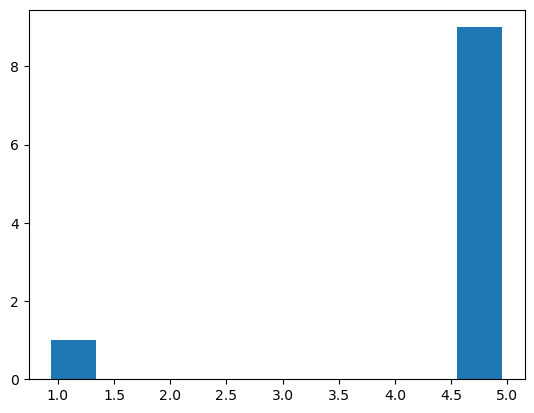

In [15]:
random_samp_idxs=np.random.choice(hyperpost_samps.shape[0],10)
plt.hist(hyperpost_samps[random_samp_idxs][:,1])

In [14]:
submodels_dict = {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, 1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}

In [16]:
likelihoods = np.zeros((obsdata.shape[0], random_samp_idxs.shape[0]))

for i, sampler_hyperposts in tqdm(enumerate(hyperpost_samps[random_samp_idxs])):
    for e, event in enumerate(obsdata):
        event_shaped = np.reshape(event,(1,10000,4))
        likelihoods[e,i] = sample.lnlike(sampler_hyperposts, event_shaped, flow, submodels_dict, channels, p_theta[e,:], use_flows=True, smallest_N=1000)

10it [12:03, 72.36s/it]


False
4.381132150025236e-05
False
6.729182694887189e-05
False
4.689951356315839e-05
False
0.0003116524280599962
False
7.74796555562882e-05
False
4.9240326165139e-05
False
2.030741836577962e-06
False
0.0003116524280599962
False
4.04837536393459e-06
False
1.773552662111602e-05
False
5.866818874944047e-05
False
3.6223965585170396e-05
False
7.618788133885049e-05
False
0.0003116524280599962
False
2.2859091072920956e-05
False
0.0001363620103351385
False
1.3362260924633747e-06
False
0.0006421811779396612
False
8.504218358502234e-05
False
0.0005709669714792913
False
0.0006421811779396612
False
3.1119099075426734e-05
False
0.0006421811779396612
False
0.00018223802715367266
False
1.691545486539507e-05
False
0.0006421811779396612
False
0.0006421811779396612
False
5.016709463447145e-05
False
4.8835801473730484e-05
False
8.401226008868846e-05
False
7.077308566885654e-05
False
0.0006421811779396612
False
1.3959472552824468e-05
False
6.511731670377484e-05
False
0.00021613475606766574
False
1.69272639

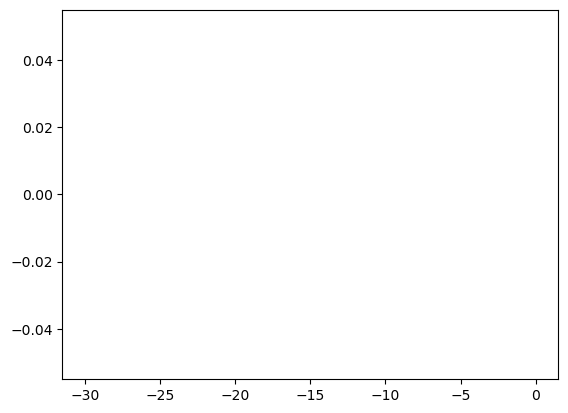

In [7]:
for e in range(60):
    print(np.any(p_theta[e, :]==0.))
    plt.hist(np.log(p_theta[e,:]), bins=40, range=(-30,0), alpha=0.5)
    print(np.min(p_theta[e,:]))
#plt.hist((p_theta[-2,:]), bins=40, alpha=0.5)

-0.25366616134238706
100.12518452183602


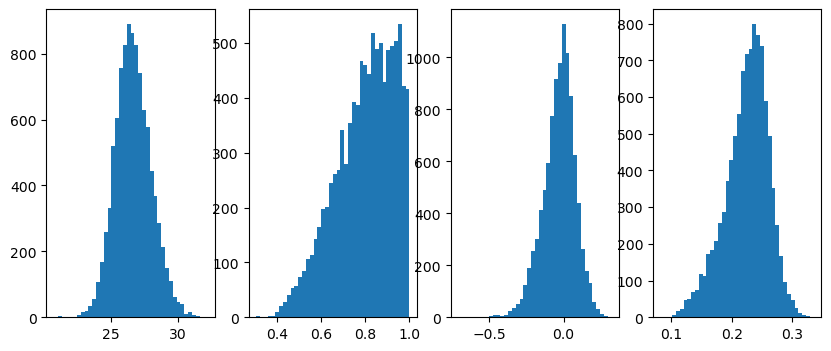

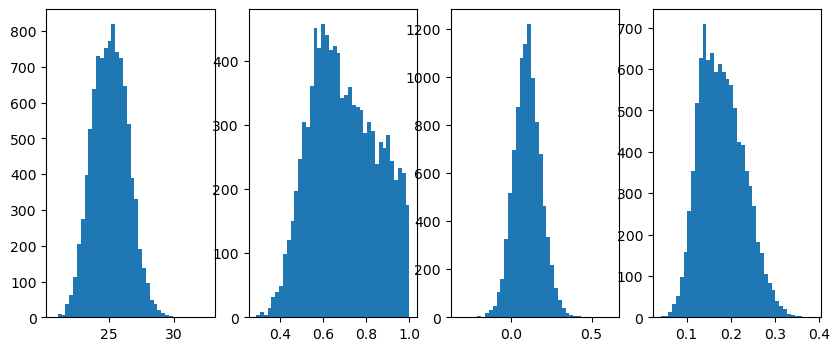

In [75]:
plt.rcParams["figure.figsize"] = (10,4)
for e in range(2):
    fig,ax=plt.subplots(1,4)
    for i in range(4):
        ax[i].hist(obsdata[-e,:,i], bins=40)
    print(np.mean(likelihoods[-e,:]))

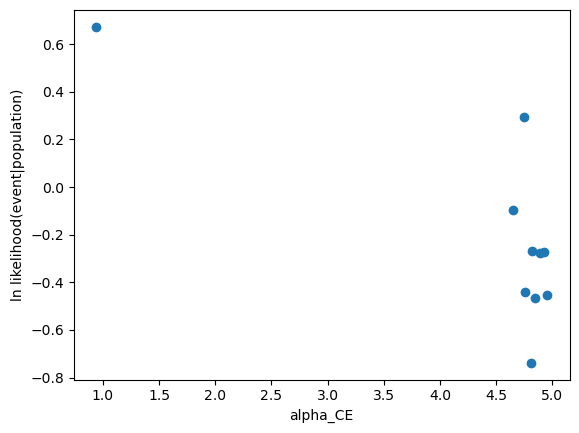

In [17]:
#plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods_10000Nsamp)
plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods[0,:])
plt.xlabel('alpha_CE')
plt.ylabel('ln likelihood(event|population)')
#plt.yscale('log')
plt.show()

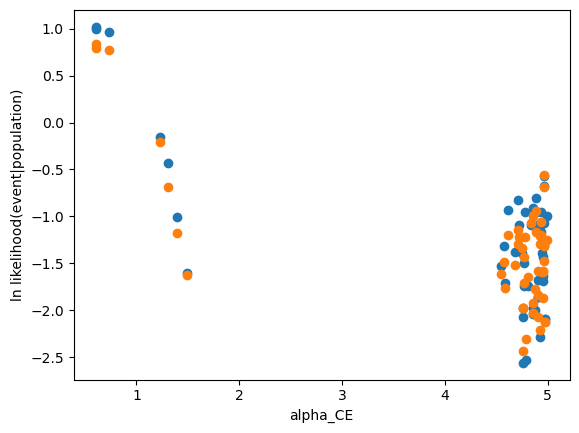

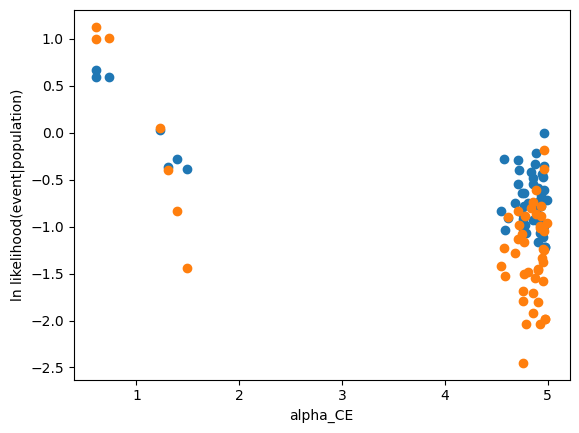

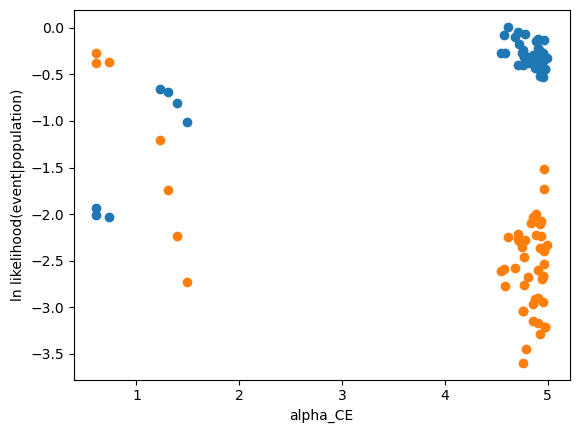

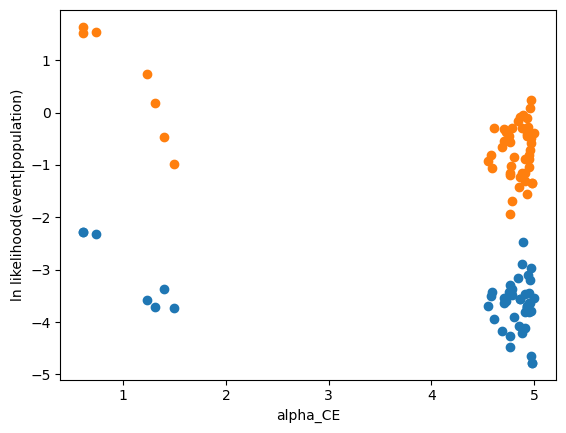

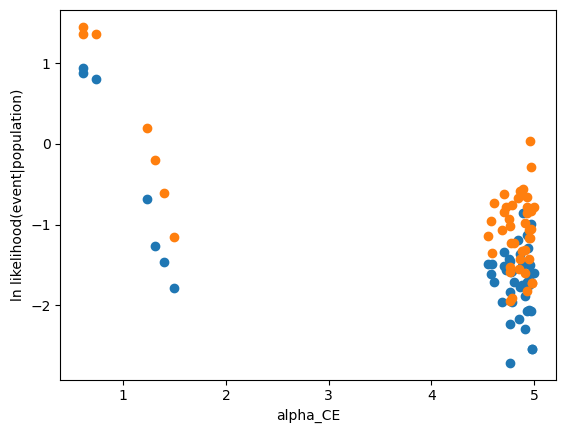

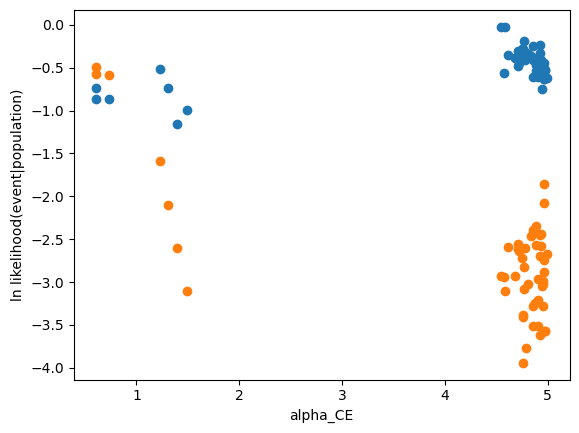

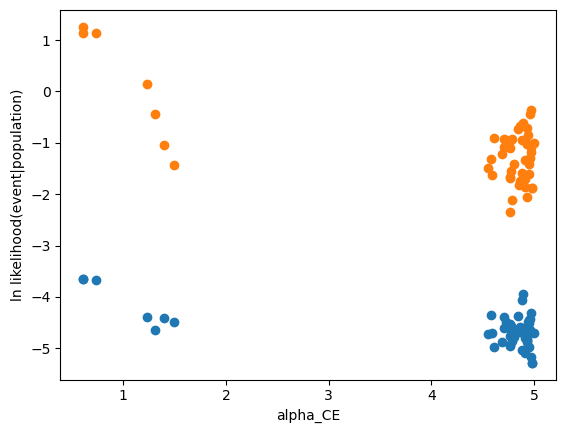

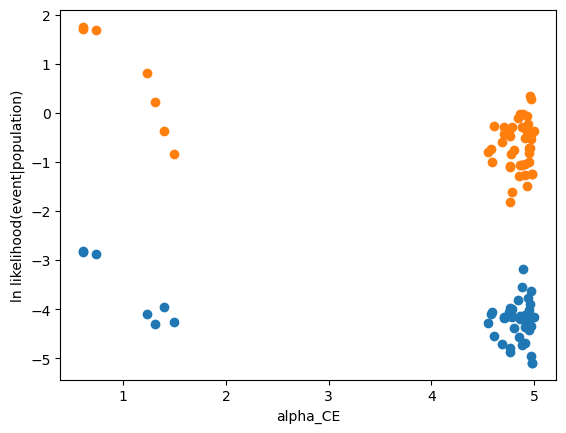

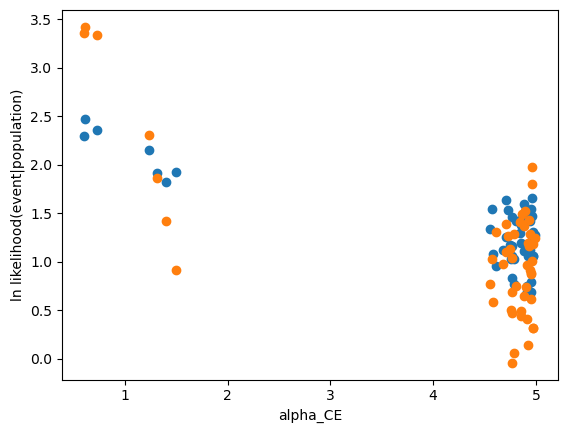

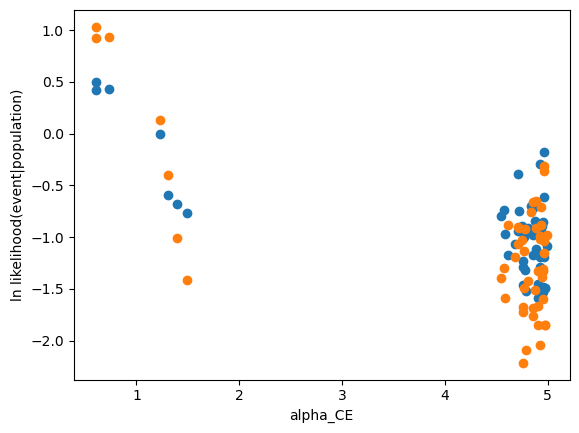

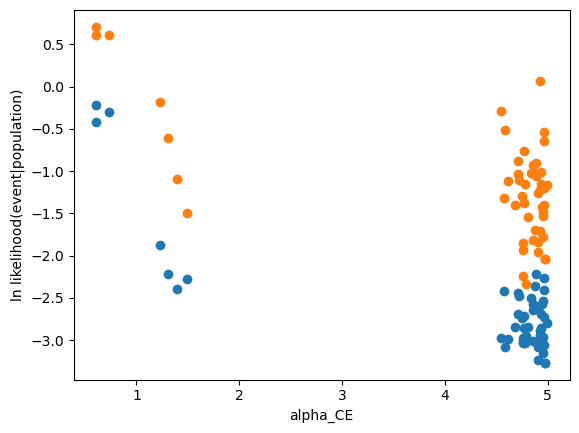

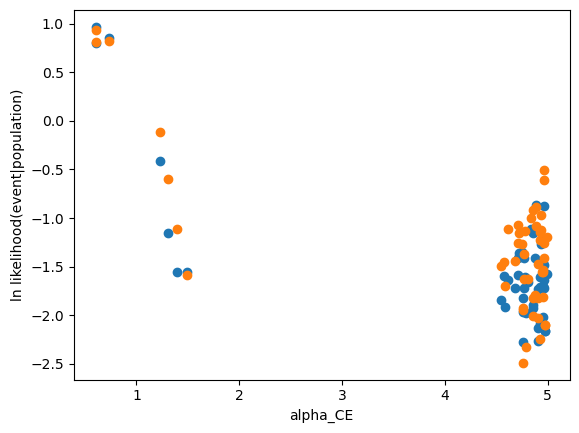

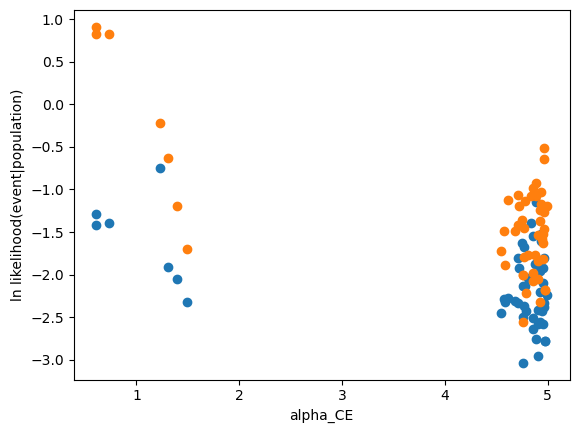

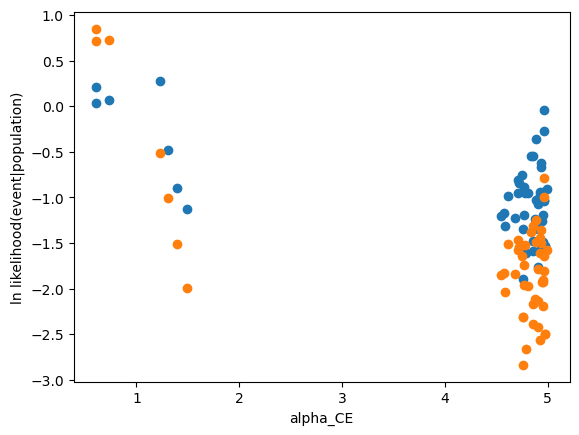

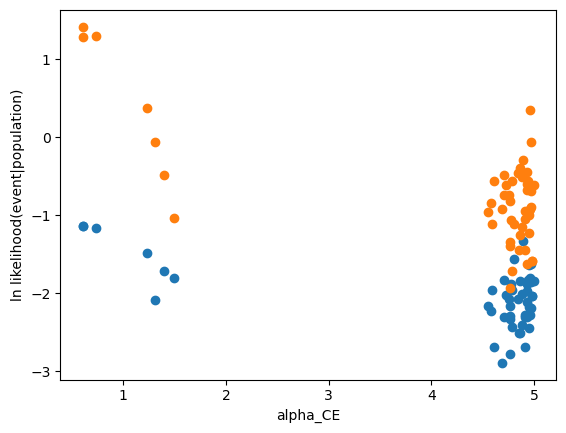

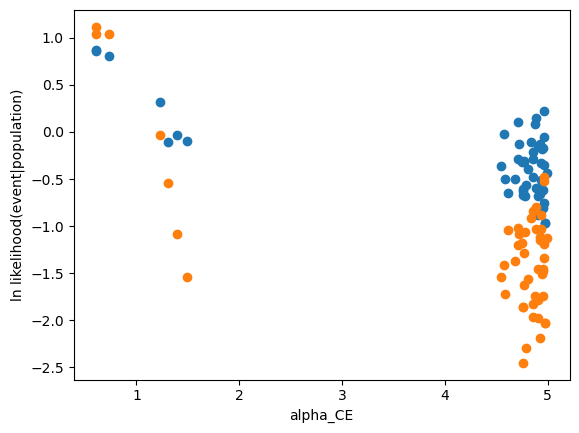

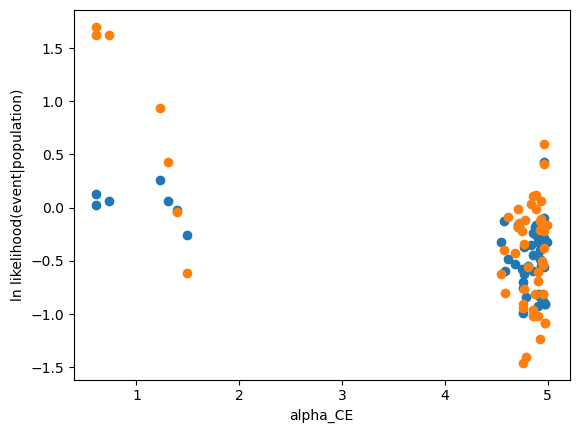

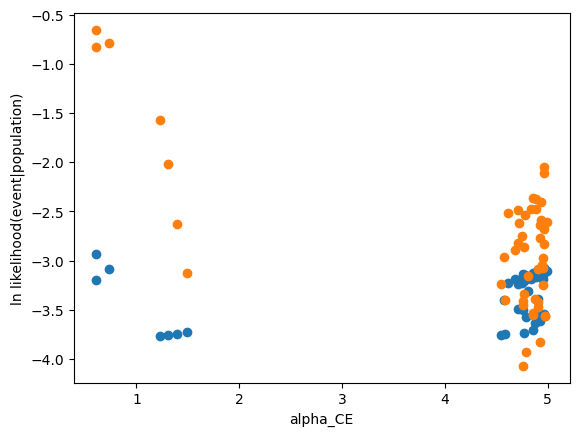

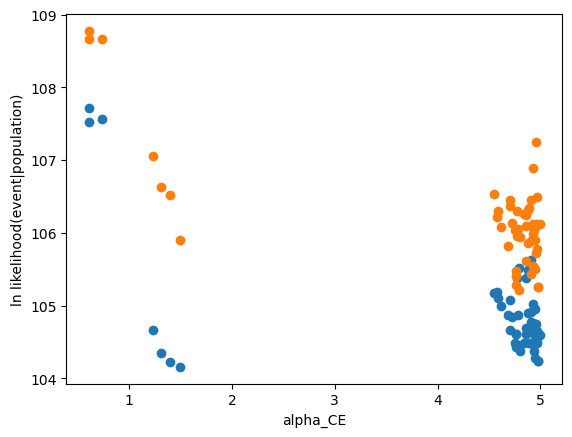

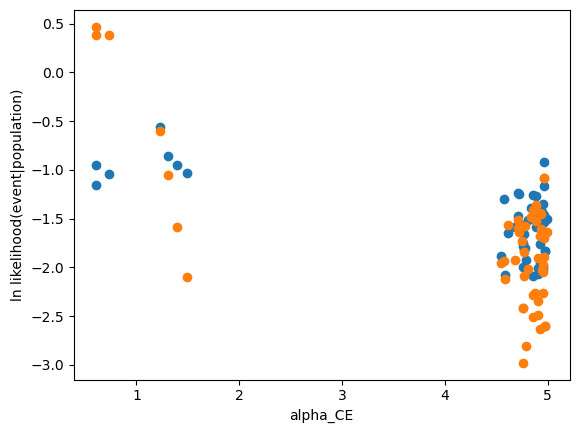

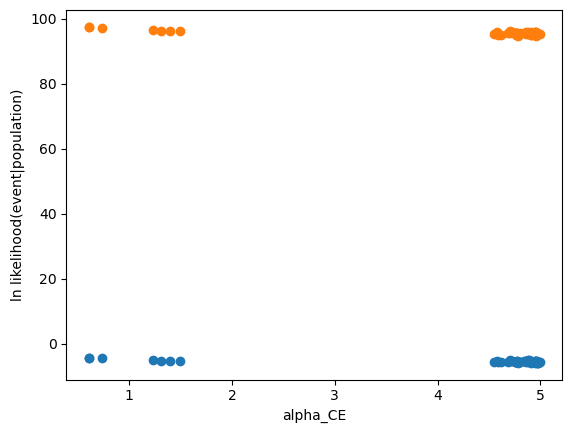

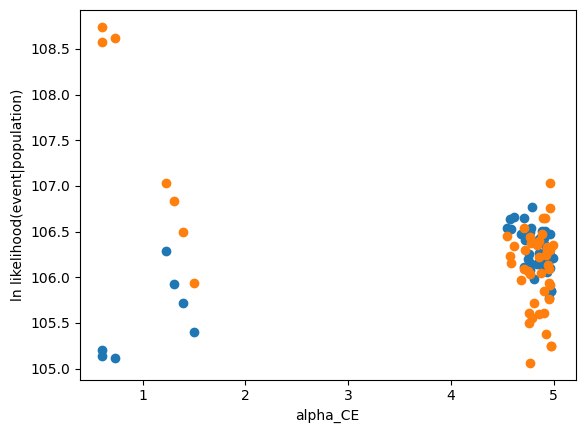

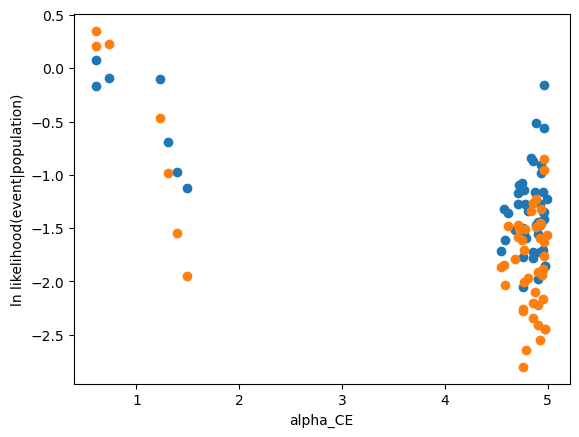

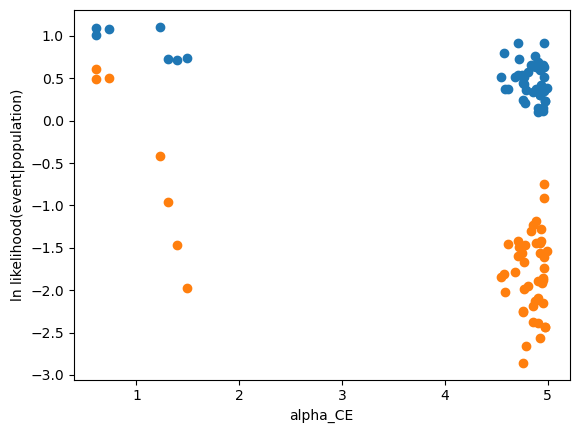

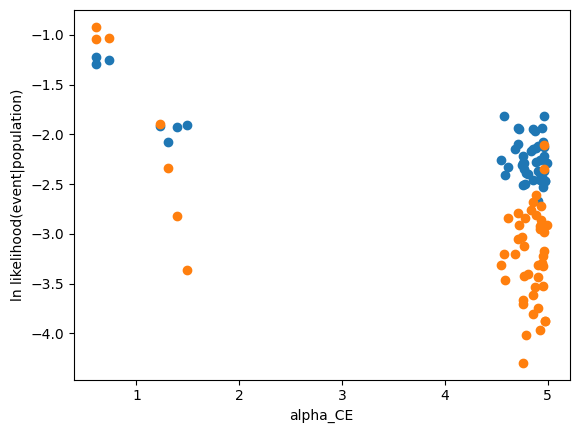

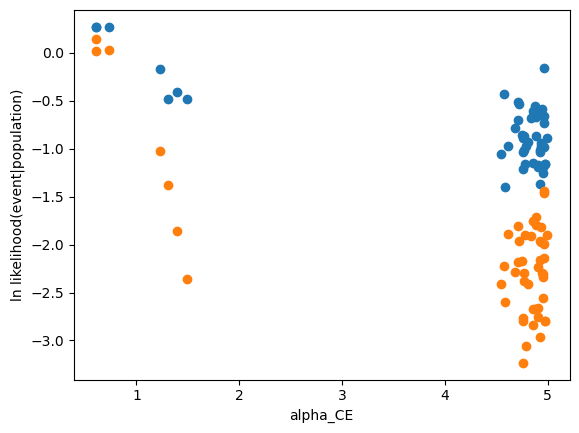

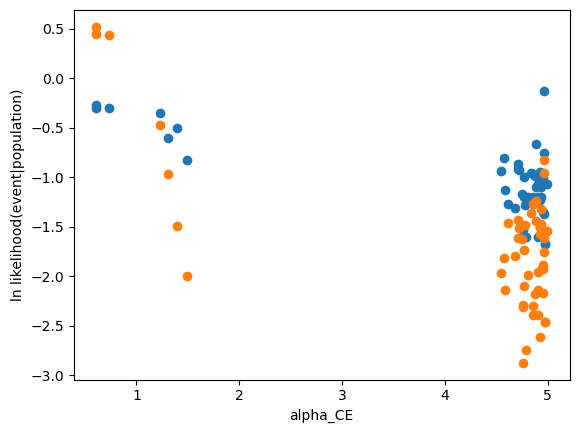

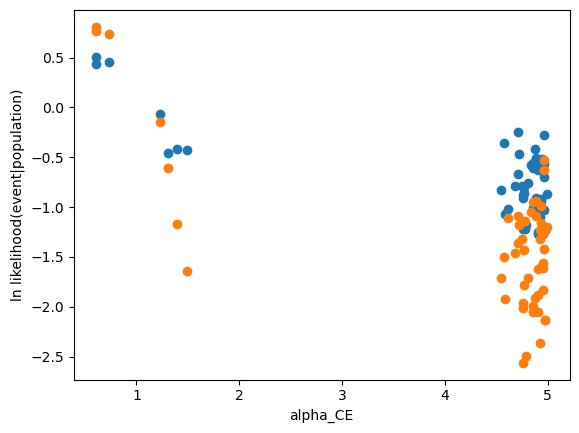

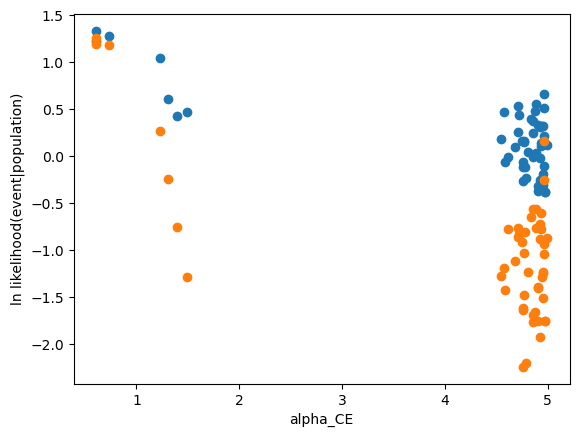

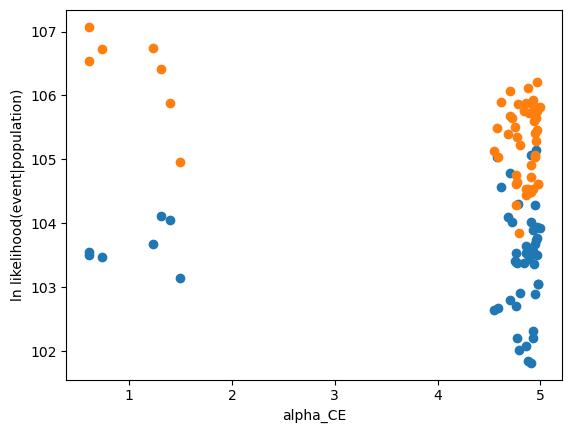

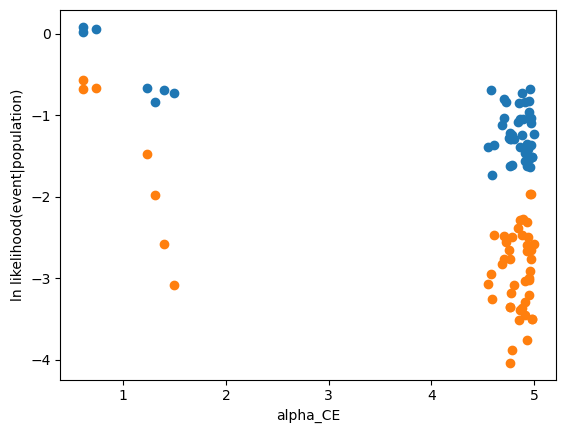

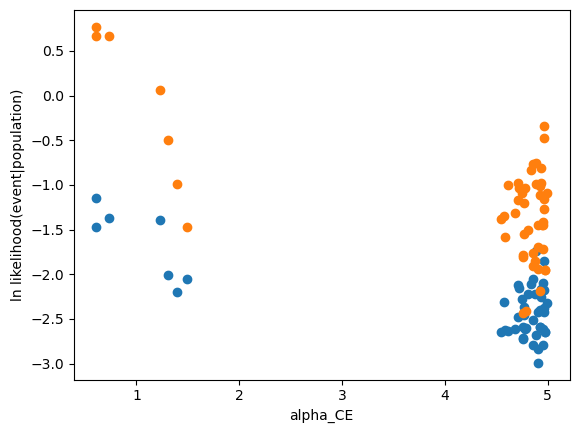

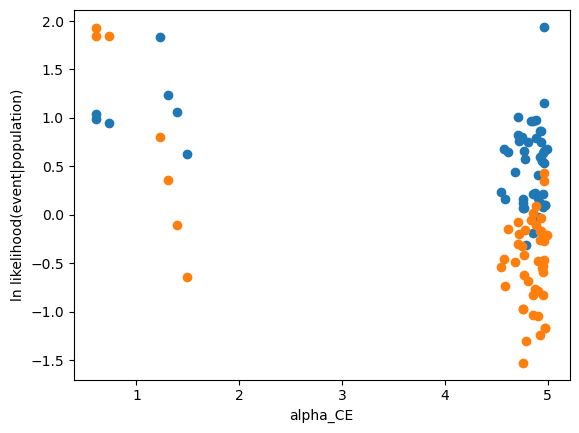

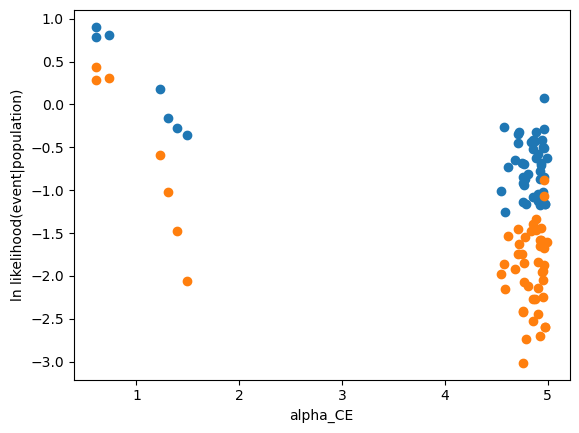

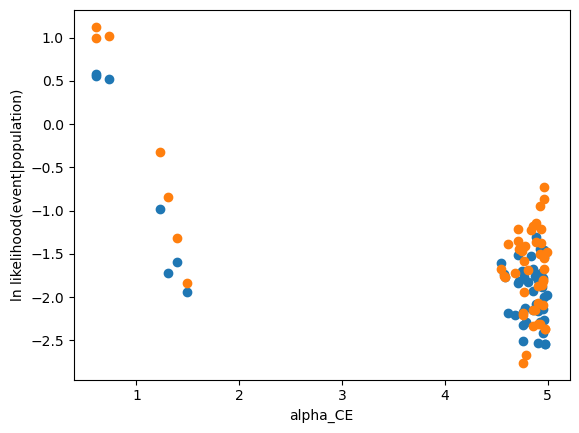

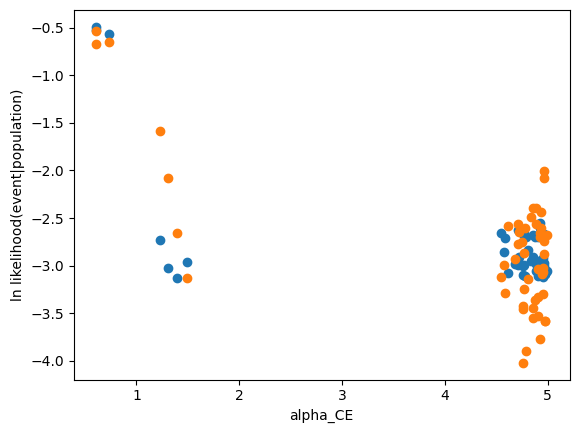

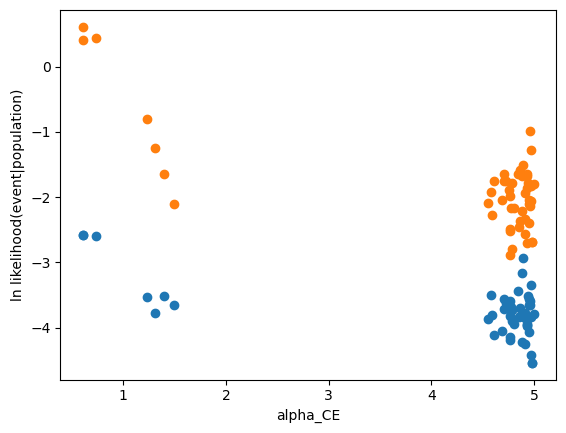

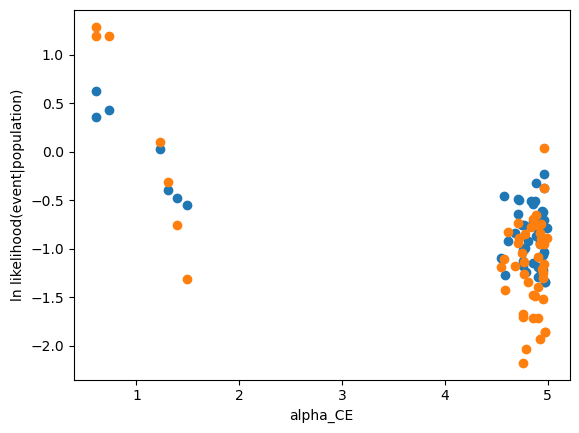

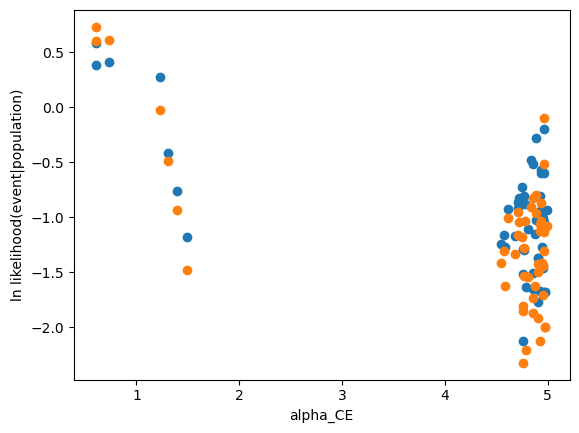

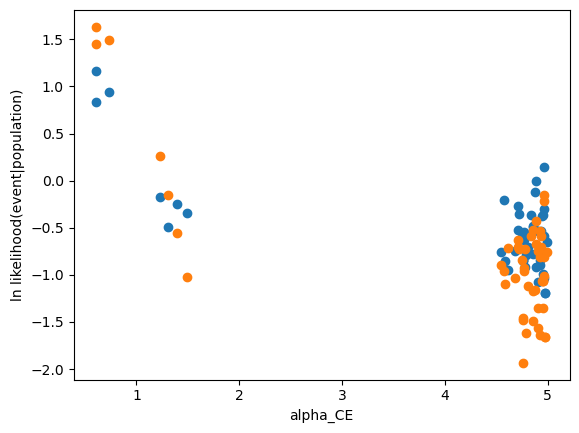

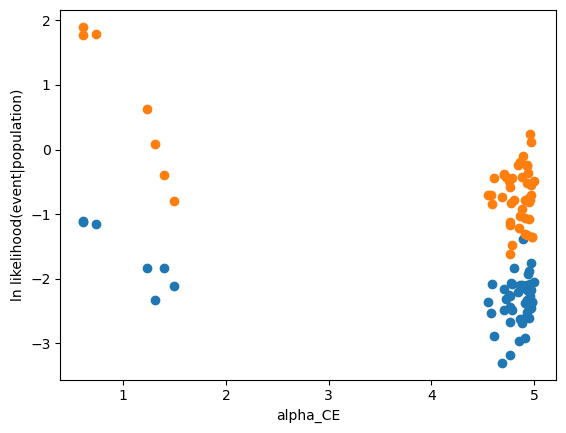

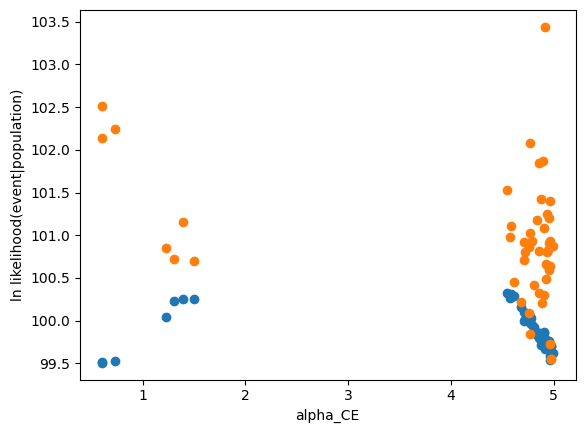

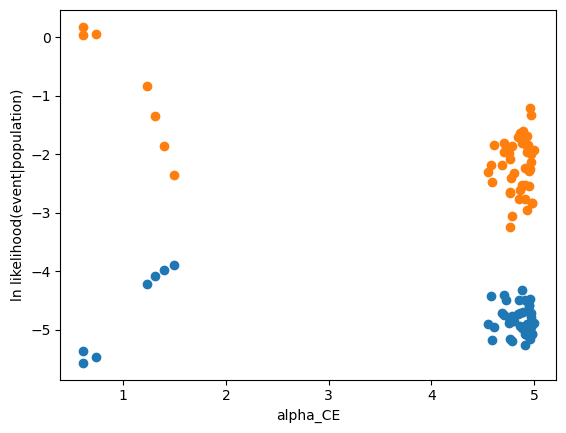

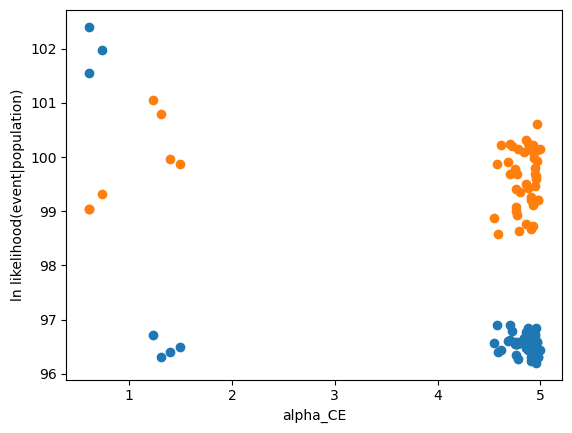

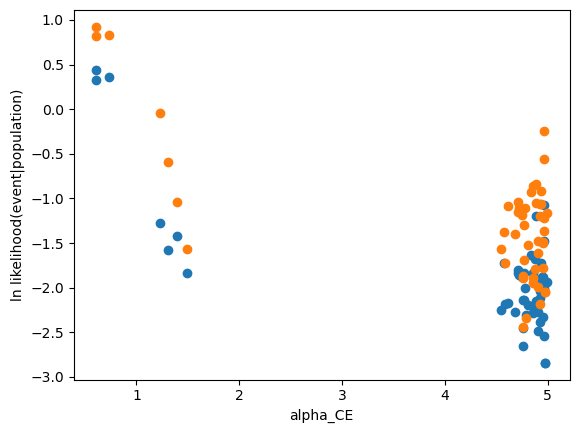

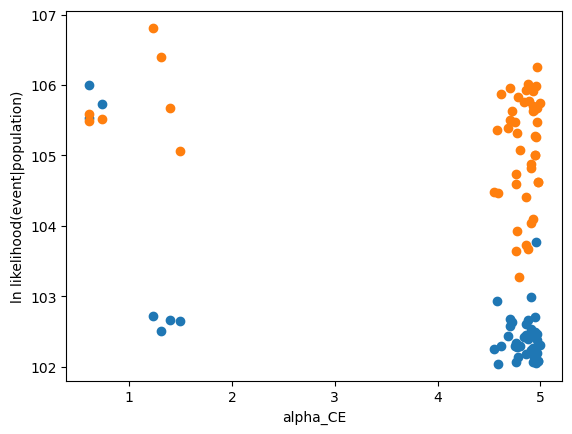

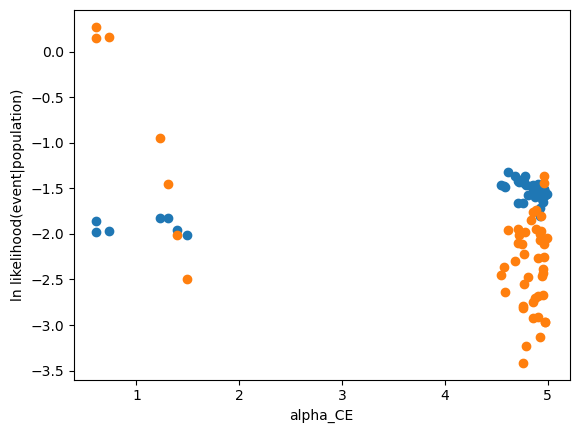

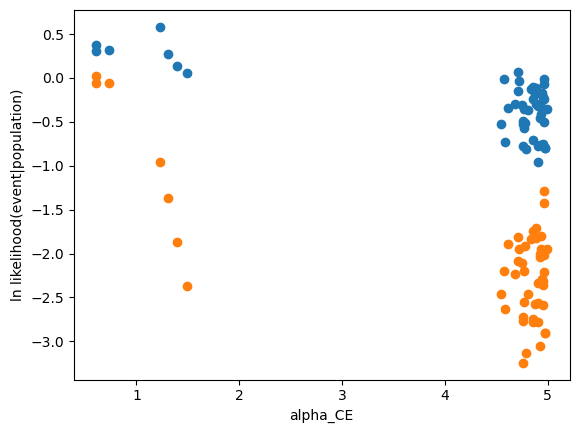

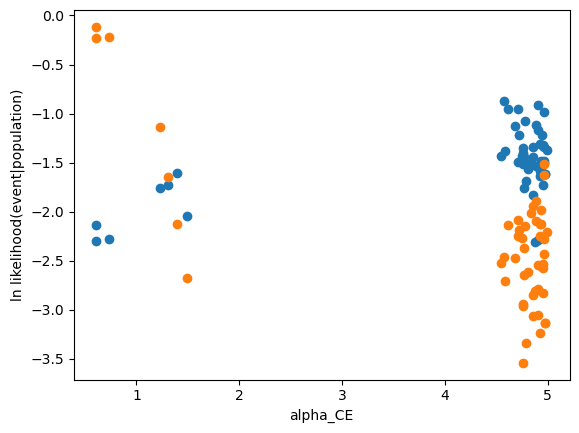

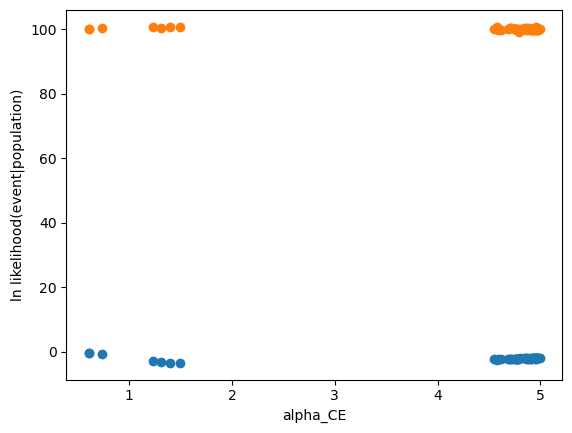

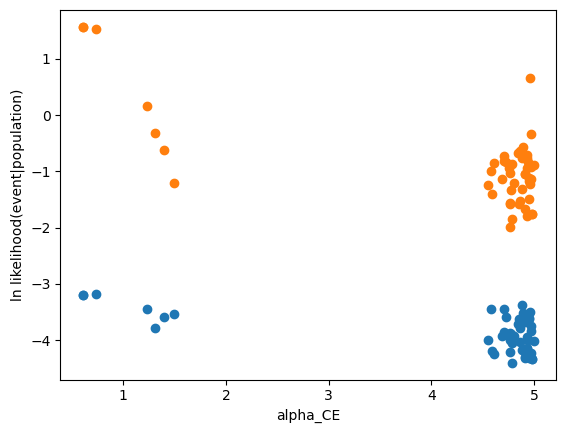

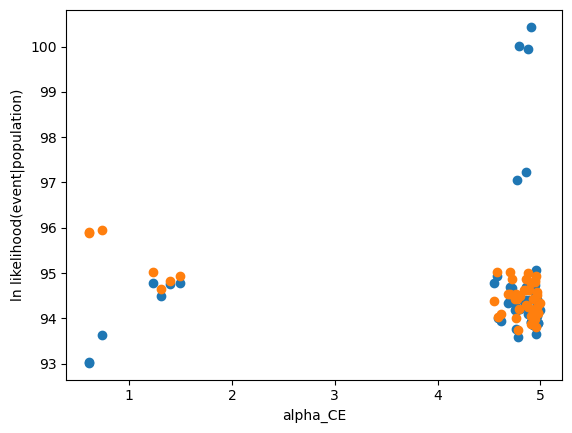

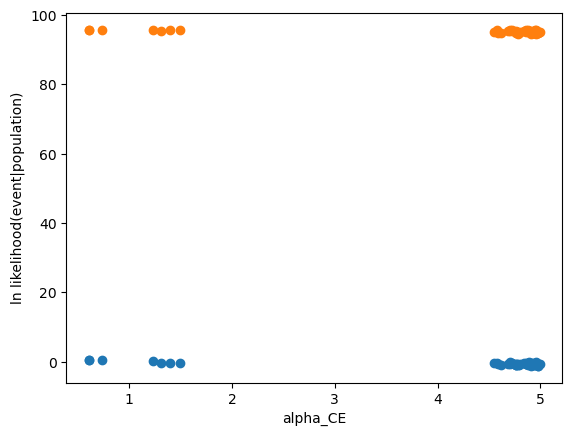

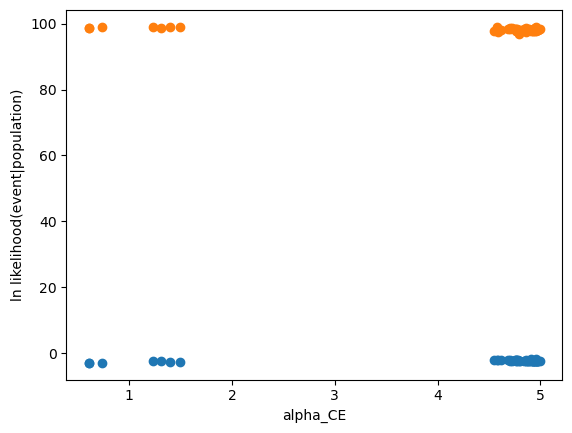

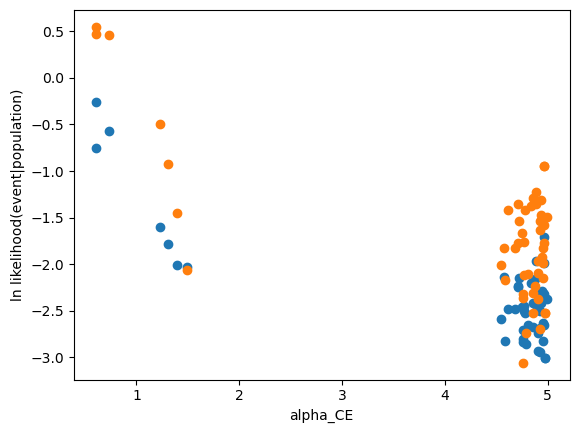

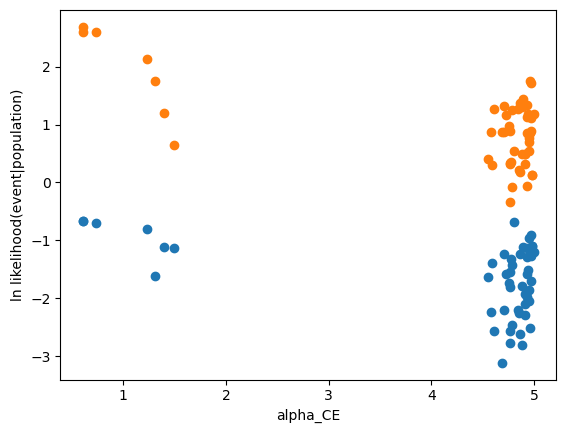

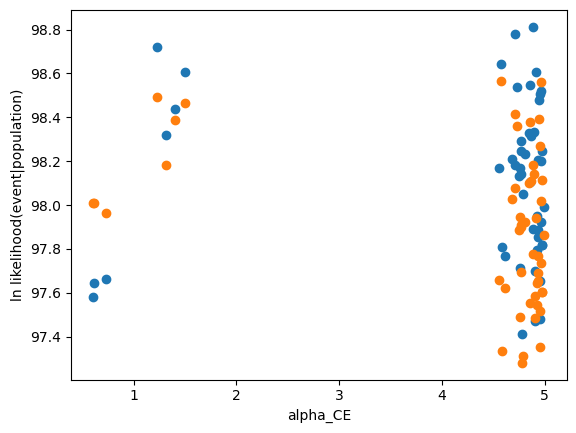

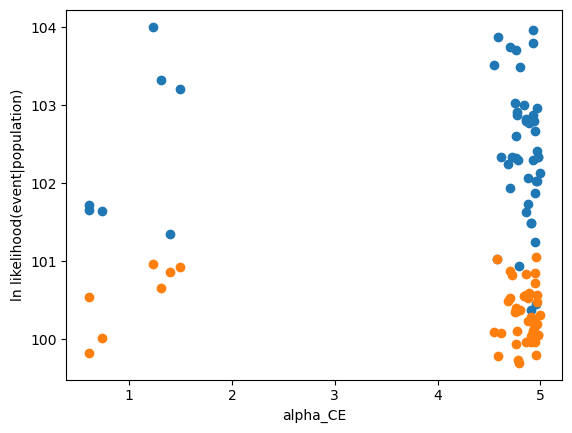

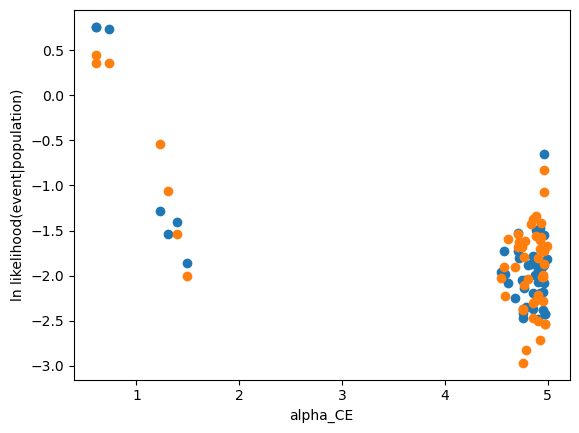

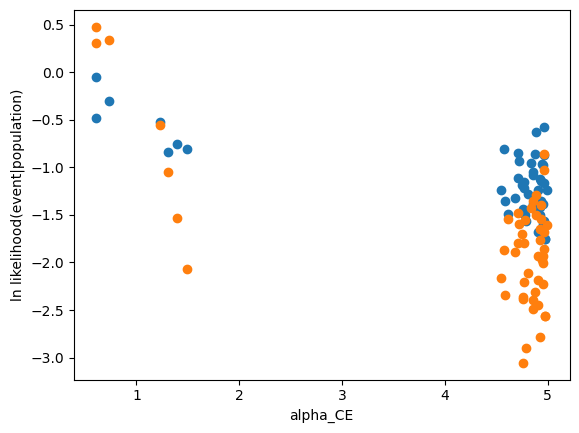

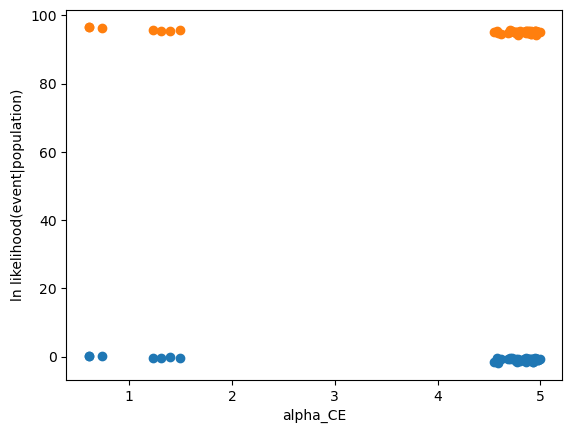

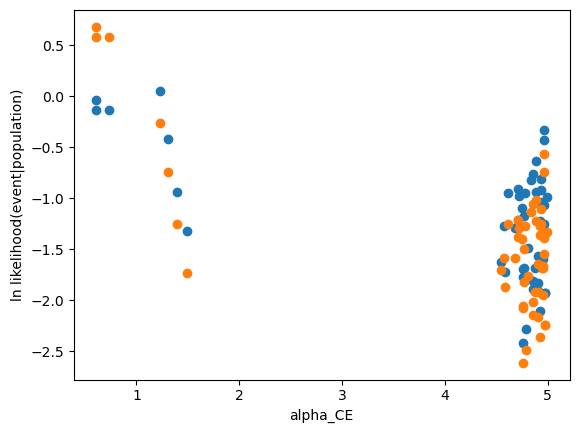

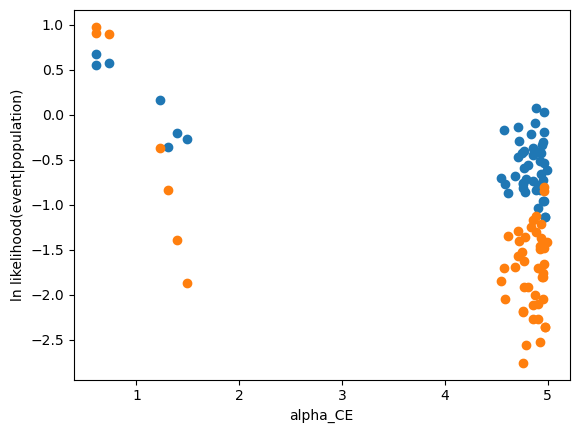

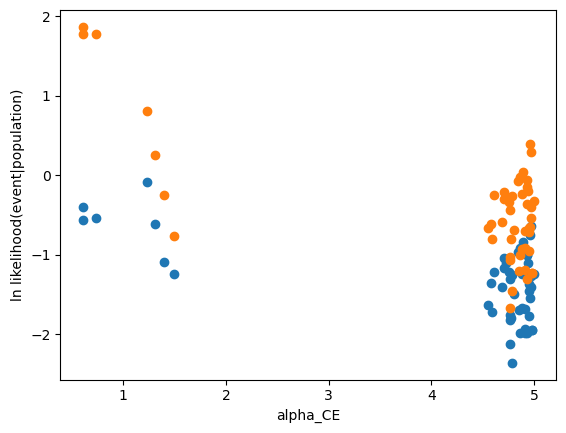

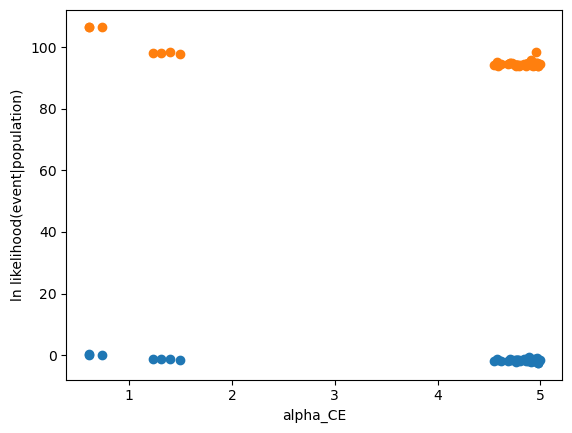

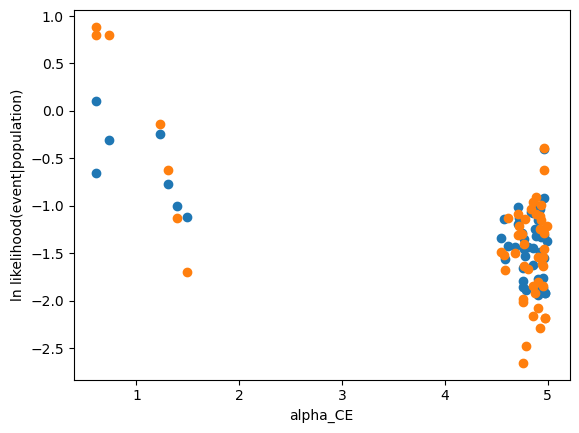

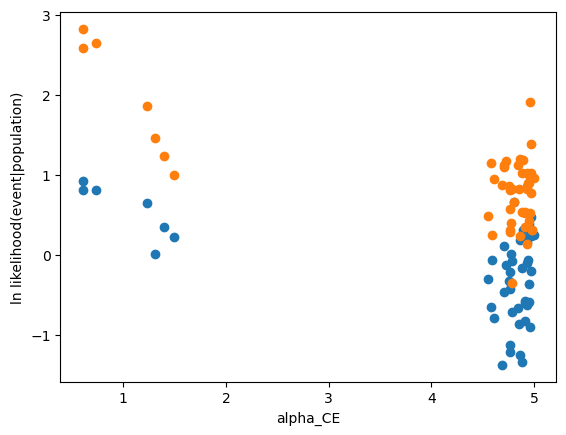

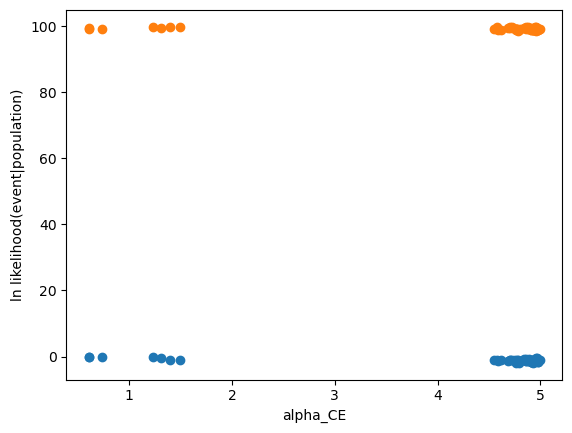

In [76]:
for e, event in enumerate(obsdata):
    plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods[e,:])
    plt.xlabel('alpha_CE')
    plt.ylabel('ln likelihood(event|population)')
    #plt.yscale('log')
    plt.show()

In [7]:
likelihoods_noprior = np.zeros((68, 10))
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', 'p_theta')

for i, sampler_hyperposts in tqdm(enumerate(hyperpost_samps[random_samp_idxs[:10]])):
    for e, event in enumerate(obsdata):
        event_shaped = np.reshape(event,(1,100,4))
        likelihoods_noprior[e,i] = sample.lnlike(sampler_hyperposts, event_shaped, flow, submodels_dict, channels, p_theta[e,:], use_flows=True, smallest_N=1000)

10it [00:51,  5.19s/it]


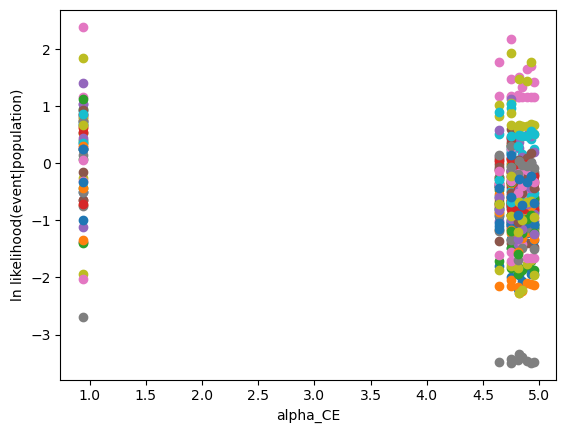

In [18]:
for e, event in enumerate(obsdata):
    plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods[e,:])
    plt.xlabel('alpha_CE')
    plt.ylabel('ln likelihood(event|population)')
    #plt.yscale('log')
    #plt.show()

Text(0, 0.5, 'sum(log likelihood/prior)')

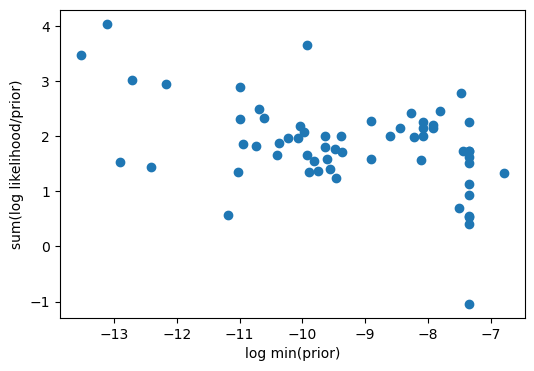

In [19]:
likelihood_sum = []
prior_sum = []
prior_min = []
plt.rcParams["figure.figsize"] = (6,4)
for e in range(len(obsdata[:,0,0])):
    likelihood_sum.append(np.sum(np.exp(likelihoods[e,:])))
    prior_sum.append(np.sum(p_theta[e,:]))
    prior_min.append(np.min(p_theta[e,:]))

plt.scatter(np.log(prior_min), np.log(likelihood_sum))
plt.xlabel('log min(prior)')
plt.ylabel('sum(log likelihood/prior)')

Text(0.5, 0, 'sum(prior)')

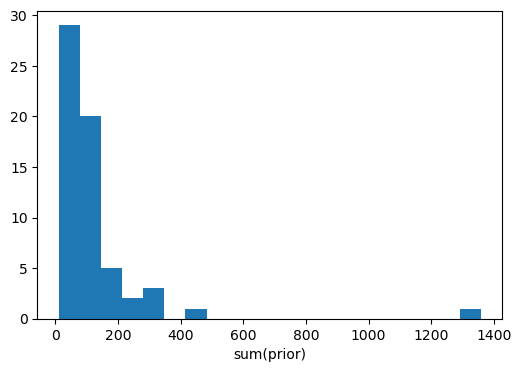

In [101]:
plt.hist(prior_sum, bins=20)
plt.xlabel('sum(prior)')

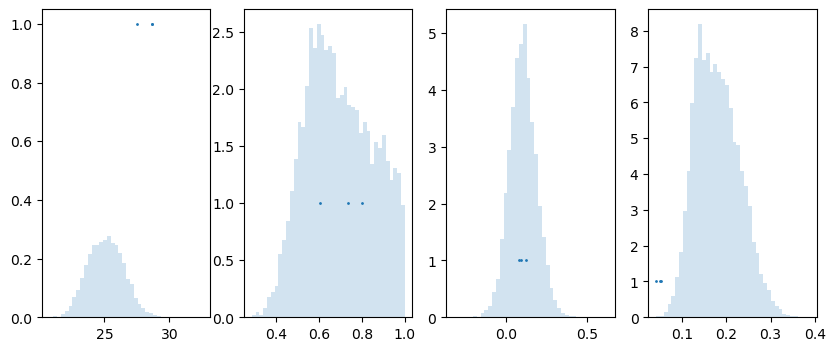

In [125]:
plt.rcParams["figure.figsize"] = (10,4)
fig,ax=plt.subplots(1,4)
for i in range(4):
    ax[i].scatter(obsdata[-1,p_theta[-1,:]==1e-50,i], [1.,1.,1.], s=1.)
    ax[i].hist(obsdata[-1,:,i], bins=40,alpha=0.2, density=True)


In [20]:
for event_idx in np.where(likelihoods[:,0]>80.)[0]:
    fig,ax=plt.subplots(1,4)
    for i in range(4):
        ax[i].scatter(obsdata[event_idx,p_theta[event_idx,:]<1e-50,i], 0.2*np.ones(len(obsdata[event_idx,p_theta[event_idx,:]<1e-50,i])), s=1.)
        ax[i].hist(obsdata[event_idx,:,i], bins=40,alpha=0.2, density=True)